In [1]:
# default_exp analyses

# Alternative Contiguity Analysis
Are contextual associations revealed during free recall stronger for the original or the secondary (or the tertiary) presentation context of repeatedly studied items?

To find out, perform lag-CRP analysis transformed to:
- Only consider transitions from a repeatedly studied item
- Separately measure using lags from primary and secondary (and tertiary) presentation positions

## Function

In [2]:
from repetition_cmr.analyses import recall_by_all_study_positions

In [37]:
# export

from numba import njit
import numpy as np

@njit(nogil=True)
def repetition_contiguity(trials, presentations, lag_threshold = 4, max_repeats = 2):
    
    list_length = len(presentations[0])
    lag_range = list_length - 1
    total_actual_lags = np.zeros((max_repeats, lag_range * 2 + 1)) # extended dimension to split by pres positions
    total_possible_lags = np.zeros((max_repeats, lag_range * 2 + 1))
    terminus = np.sum(trials != 0, axis=1) # number of recalls per trial
    recall_by_study_position = recall_by_all_study_positions(trials, presentations, max_repeats)
    
    for trial_index in range(len(trials)):
        previous_item = 0
        item_count = np.max(presentations[trial_index]) + 1
        possible_items = np.arange(item_count) # initial pool of possible recalls, 1-indexed
        possible_positions = np.zeros((item_count, max_repeats), dtype=np.int32)
        
        # we track possible positions using presentations and alt_presentations
        for item in range(item_count):
            pos = np.nonzero(presentations[trial_index] == item)[0] + 1
            possible_positions[item, :len(pos)] = pos
            
        for recall_index in range(terminus[trial_index]):

            current_item = presentations[trial_index][trials[trial_index, recall_index]-1]
            
            # track possible and actual lags; 
            # focus only on transitions from items with > 1 study positions
            # and only when those multiple study positions have lag over lag
            if recall_index > 0 and np.count_nonzero(
                possible_positions[previous_item]) > 1 and (
                possible_positions[previous_item][1] - possible_positions[previous_item][0] >= lag_threshold):
                #possible_positions[previous_item][1] - possible_positions[previous_item][0] >= lag_threshold) and (
                #possible_positions[previous_item][2] - possible_positions[previous_item][1] >= 6):
                
                # item indices don't help track lags anymore
                # so more complex calculation needed to identify possible lags given previous item
                current_index = np.nonzero(possible_items==current_item)[0]

                index = 0
                for x in range(len(recall_by_study_position)):
                    for y in range(len(recall_by_study_position)):
                        if possible_positions[previous_item, y] > 0:
                        
                            possible_lags = possible_positions[
                                possible_items, x] - possible_positions[previous_item, y]
                            
                            # if tracked position is 0, then we don't actually want to count it in our lags
                            possible_lags[possible_positions[possible_items, x] == 0] = 0
                            
                            # we track actual lag at each iteration
                            actual_lag = possible_lags[current_index] + lag_range
                            total_actual_lags[y][actual_lag] += 1

                            # we track possible lag at each iteration
                            possible_lags += lag_range
                            total_possible_lags[y][possible_lags] += 1
                        
                        index += 1

            # update pool to exclude recalled item (updated to still identify 1-indexed item)
            previous_item = current_item
            possible_items = possible_items[possible_items != previous_item]

                                
    # small correction to avoid nans and commit to excluding multiply-tracked single presentations 
    total_actual_lags[:, lag_range] = 0
    for i in range(max_repeats):
        total_possible_lags[i][total_actual_lags[i]==0] += 1
    
    return total_actual_lags/total_possible_lags

In [35]:
# export

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from compmemlearn.datasets import events_metadata, generate_trial_mask

def plot_repetition_contiguity(
    data, trial_query, contrast_name='', labels=None, axis=None, minimum_lag=8, repetition_count=2, repetition_interval='01', rigid=True):
    max_lag = 3

    if labels is None:
        labels = [''] * len(data)

    for data_index, events in enumerate(data):

        plt.figure()
        axis = plt.gca()
        result = []

        # generate and subset trials array and list of list_lengths based on trial_query
        trials, list_lengths, presentations = events_metadata(events)
        trial_mask = generate_trial_mask(events, trial_query)
        chose = [i for i in range(len(trial_mask)) if np.sum(trial_mask[i]) != 0]
        assert(len(chose) == 1)
        chose = chose[0]
        trials = trials[chose]
        list_length = list_lengths[chose]
        presentations = presentations[chose]
        trial_mask = trial_mask[chose]

        # use static parameters depending on dataset if we've allowed rigid to be True
        if rigid:
            if np.sum(presentations[0][0] == presentations[0]) > 2:
                repetition_count = 3
                minimum_lag = 10
            else:
                repetition_count = 2
                minimum_lag = 8

        lag_interval = np.arange(-max_lag, max_lag+1, dtype=int)
        lag_range = list_length -1
        for subject in pd.unique(events.subject):
            subject_specific_trial_mask = np.logical_and(
                generate_trial_mask(events, f"subject == {subject}")[chose], trial_mask
            )

            if np.sum(subject_specific_trial_mask) == 0:
                continue
            rep_con = repetition_contiguity(
                trials[subject_specific_trial_mask], presentations[subject_specific_trial_mask], lag_threshold=minimum_lag, max_repeats=repetition_count)
            if np.sum(rep_con) == 0:
                continue
            rep_con[:, lag_range] = np.nan
            
            for repetition in repetition_interval:
                result.append(pd.DataFrame.from_dict(
                    {
                        "subject": subject,
                        "Presentation Position": int(repetition) + 1,
                        "lag": lag_interval,
                        "prob": rep_con[int(repetition)][lag_range-max_lag:lag_range+max_lag+1]
                    }
                ))

        result = pd.concat(result)

        color = None if len(data) == 1 else 'blue'
        filt_neg = f'{-max_lag} <= lag < 0'
        filt_pos = f'0 < lag <= {max_lag}'

        sns.lineplot(ax=axis, data=result.query(filt_neg), x='lag', y='prob', palette='tab10',
                    err_style='bars', hue="Presentation Position", legend=False, color=color)
        sns.lineplot(ax=axis, data=result.query(filt_pos), x='lag', y='prob', palette='tab10',
                    err_style='bars', hue="Presentation Position", color=color)
        axis.set(xlabel='Item\'s Lag From Repeated Item\'s First or Second Presentation', ylabel='Conditional Recall Rate')
        axis.set_xticks(np.arange(-max_lag, max_lag+1, 1))
        #axis.set_ylim((0, 1))
        axis.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

    return axis

In [5]:
# export

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from compmemlearn.datasets import events_metadata, generate_trial_mask

def plot_trial_repetition_contiguity(
    data, trial_query, contrast_name='', labels=None, axis=None, minimum_lag=8, repetition_count=2, repetition_interval='01', rigid=True):

    max_lag = 3
    if labels is None:
        labels = [''] * len(data)

    for data_index, events in enumerate(data):

        plt.figure()
        axis = plt.gca()
        result = []

        # generate and subset trials array and list of list_lengths based on trial_query
        trials, list_lengths, presentations = events_metadata(events)
        trial_mask = generate_trial_mask(events, trial_query)
        chose = [i for i in range(len(trial_mask)) if np.sum(trial_mask[i]) != 0]
        assert(len(chose) == 1)
        chose = chose[0]
        trial_mask = trial_mask[chose]
        trials = trials[chose][trial_mask]
        list_length = list_lengths[chose]
        presentations = presentations[chose][trial_mask]

        if rigid:
            if np.sum(presentations[0][0] == presentations[0]) > 2:
                repetition_count = 3
                minimum_lag = 10
            else:
                repetition_count = 2
                minimum_lag = 8

        lag_interval = np.arange(-max_lag, max_lag+1, dtype=int)
        lag_range = list_length -1
        for trial_index, trial in enumerate(trials):
            rep_con = repetition_contiguity(
                np.expand_dims(trial, 0), np.expand_dims(presentations[trial_index], 0), lag_threshold=minimum_lag, max_repeats=repetition_count
            )
            if np.sum(rep_con) == 0:
                continue
            rep_con[:, lag_range] = np.nan

            for repetition in repetition_interval:
                result.append(pd.DataFrame.from_dict(
                    {
                        "Presentation Position": int(repetition) + 1,
                        "lag": lag_interval,
                        "prob": rep_con[int(repetition)][lag_range-max_lag:lag_range+max_lag+1]
                    }
                ))

        result = pd.concat(result)
        color = None if len(data) == 1 else 'blue'
        filt_neg = f'{-max_lag} <= lag < 0'
        filt_pos = f'0 < lag <= {max_lag}'

        sns.lineplot(ax=axis, data=result.query(filt_neg), x='lag', y='prob', palette='tab10',
                    err_style='bars', hue="Presentation Position", legend=False, color=color)
        sns.lineplot(ax=axis, data=result.query(filt_pos), x='lag', y='prob', palette='tab10',
                    err_style='bars', hue="Presentation Position", color=color)
        axis.set(xlabel='Item\'s Lag From Repeated Item\'s First or Second Presentation', ylabel='Conditional Recall Rate')
        axis.set_xticks(np.arange(-max_lag, max_lag+1, 1))
        #axis.set_ylim((0, 1))
        axis.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

    return axis

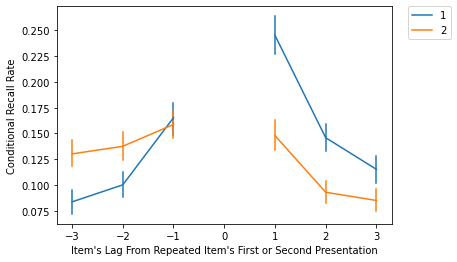

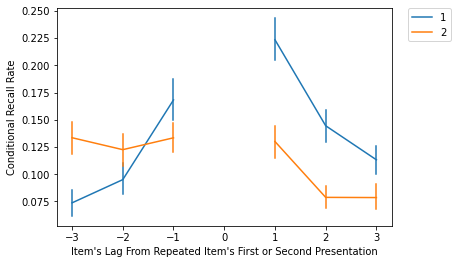

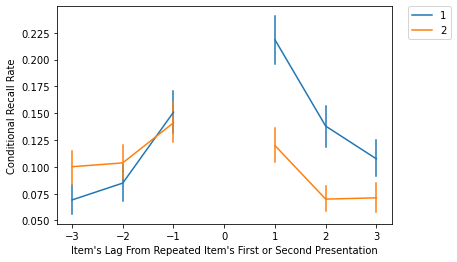

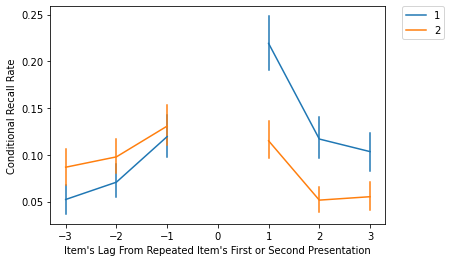

In [16]:
events = pd.read_csv('../../../compmemlearn/data/LohnasKahana2014.csv')
trials, list_lengths, presentations = events_metadata(events)
    
for minimum_lag in [2, 4, 6, 8]:
    test = plot_trial_repetition_contiguity([events], "condition > 2", minimum_lag=minimum_lag, rigid=False)

condition == 1,2, minimum_lag = 2


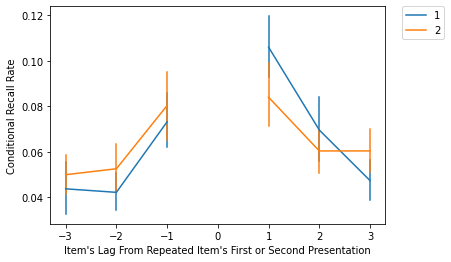

condition == 1,2, minimum_lag = 4


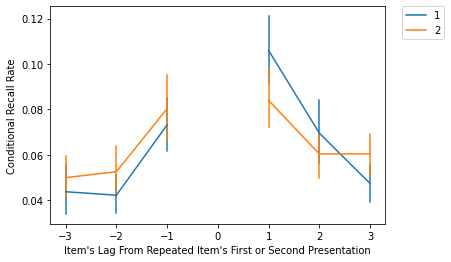

condition == 1,2, minimum_lag = 6


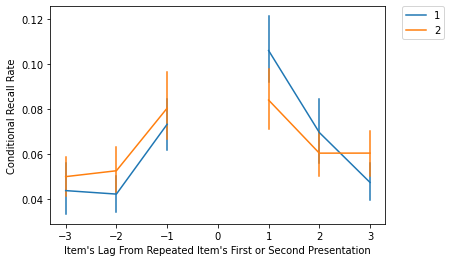

condition == 1,2, minimum_lag = 8


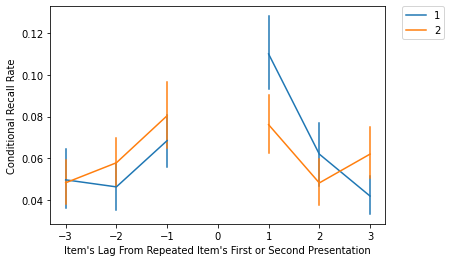

condition == 1,2, minimum_lag = 10


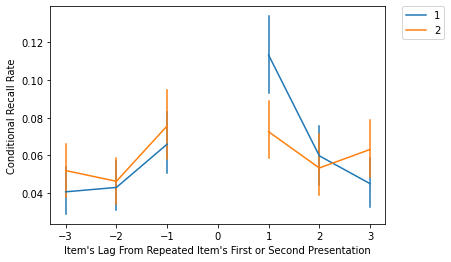

condition == 1,2, minimum_lag = 12


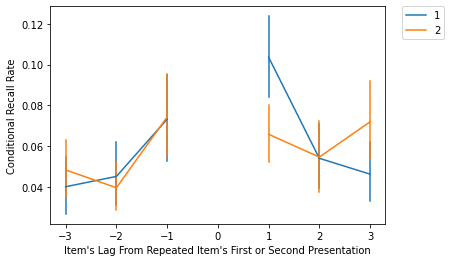

condition == 1,2, minimum_lag = 14


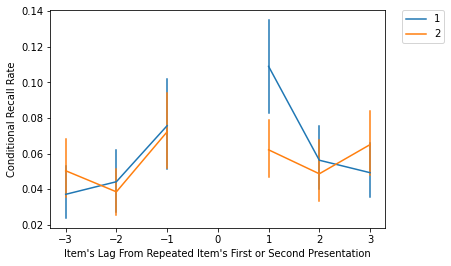

condition == 1,2, minimum_lag = 16


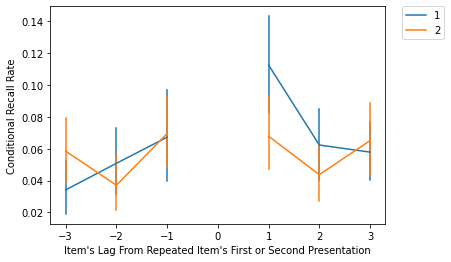

condition == 1,2, minimum_lag = 18


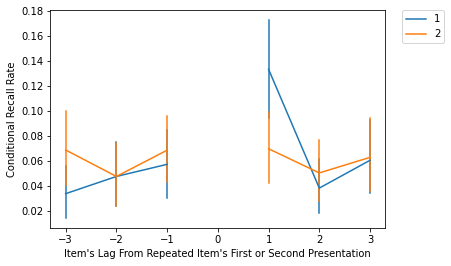

condition == 1,2, minimum_lag = 20


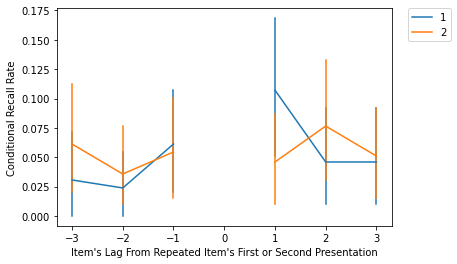

In [38]:
events = pd.read_csv('../../../compmemlearn/data/HowardKahana2005.csv')
trials, list_lengths, presentations = events_metadata(events)

for minimum_lag in [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]:
    try:
        test = plot_trial_repetition_contiguity([events], "condition == 1", minimum_lag=minimum_lag, repetition_count=3, repetition_interval='01', rigid=False)
        print(f"condition == 1,2, minimum_lag = {minimum_lag}")
        plt.show()
    except ValueError:
        continue